## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [215]:
import numpy as np
import pandas as pd
import scipy.stats as st
import requests as req
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
test = pd.read_csv('../data/test.csv')

In [3]:
flights = pd.read_csv('../data/flights_1%.csv')

In [5]:
flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-19,WN,WN,WN,493,WN,N421LV,493,13342,MKE,...,1066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-19,WN,WN,WN,51,WN,N7719A,51,13495,MSY,...,436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-12-19,WN,WN,WN,2398,WN,N724SW,2398,13495,MSY,...,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-12-19,WN,WN,WN,943,WN,N8685B,943,13796,OAK,...,407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-19,WN,WN,WN,2443,WN,N8698B,2443,13851,OKC,...,495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
flights.isna().sum()

fl_date                     0
mkt_unique_carrier          0
branded_code_share          0
mkt_carrier                 0
mkt_carrier_fl_num          0
op_unique_carrier           0
tail_num                  514
op_carrier_fl_num           0
origin_airport_id           0
origin                      0
origin_city_name            0
dest_airport_id             0
dest                        0
dest_city_name              0
crs_dep_time                0
dep_time                 2505
dep_delay                2565
taxi_out                 2656
wheels_off               2654
wheels_on                2719
taxi_in                  2721
crs_arr_time                0
arr_time                 2657
arr_delay                3057
cancelled                   0
cancellation_code      157352
diverted                    0
dup                         0
crs_elapsed_time            0
actual_elapsed_time      3023
air_time                 3085
flights                     0
distance                    0
carrier_de

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

So what kinds of numbers are we dealing with?

In [125]:
city_dates = list(
    set(flights.groupby(['origin_city_name', 'fl_date']).groups.keys()) |
    set(flights.groupby(['dest_city_name', 'fl_date']).groups.keys())
)
len(city_dates)

83424

In [182]:
flights_sample = flights.sample(2000, random_state=1234)
city_dates_sample = list(
    set(flights_sample.groupby(['origin_city_name', 'fl_date']).groups.keys()) |
    set(flights_sample.groupby(['dest_city_name', 'fl_date']).groups.keys())
)
len(city_dates_sample)

3771

In [107]:
len(
    set(test.groupby(['origin_city_name', 'fl_date']).groups.keys()) |
    set(test.groupby(['dest_city_name', 'fl_date']).groups.keys())
)

10850

In [109]:
flights.fl_date.min(), flights.fl_date.max()

('2018-01-01', '2019-12-31')

In [110]:
test.fl_date.min(), test.fl_date.max()

('2020-01-01 00:00:00', '2020-01-31 00:00:00')

Set up the Visual Crossing API call

In [179]:
def deslash(place):
    """
    Extracts only the first name in a "slashed" city name.
    
    Some cities in the flight data are for multi-city metro areas, written
    with slashes; for example, "Pasco/Kennewick/Richland, WA".
    This function pulls out only the first name so we can pass it to the
    Visual Crossing API. The example above would yield "Pasco, WA".
    """
    city, state = place.split(', ')
    city = city.split('/')[0]
    return f'{city}, {state}'

In [167]:
import visual_crossing_env
api_key = visual_crossing_env.API_KEY
url = (
    'https://weather.visualcrossing.com/'
    'VisualCrossingWebServices/rest/services/timeline'
)
def get_weather(place, date):
    response = req.get(
        f"{url}/{deslash(place)}/{date}",
        params=dict(
            unitGroup='us',
            key=api_key,
            include='obs',
        )
    )
    if response.status_code == 200:
        return response.json()
    else:
        print(response.status_code)

In [154]:
def get_weather_conditions(place, date):
    weather = get_weather(place, date)
    if weather is not None:
        return weather['days'][0]['conditions']

In [178]:
# Test call
# get_weather('Milwaukee, WI', '2018-01-01')
# get_weather_conditions('Milwaukee, WI', '2018-01-01')
# get_weather_conditions('Pasco/Kennewick/Richland, WA', '2018-11-10')

In [187]:
city_dates_split = np.array_split(np.array(city_dates_sample), 5)

In [147]:
def get_weather_for_splits(splits, split_idxs):
    result = []
    for split_idx in split_idxs:
        split_result = []
        for row in splits[split_idx]:
            city, date = row
            split_result.append([city, date, get_weather_conditions(city, date)])
        result.append(np.array(split_result))
    return np.vstack(result)

Uncomment to get new data:

In [194]:
# weather_0 = get_weather_for_splits(city_dates_split, [0])
# weather_0_df = pd.DataFrame(weather_0)
# weather_0_df.columns = ['city', 'date', 'conditions']
# weather_0_df.to_csv('weather_0.csv', index=False)

In [196]:
# for i in range(1, 5):
#     weather = get_weather_for_splits(city_dates_split, [i])
#     weather_df = pd.DataFrame(weather)
#     weather_df.columns = ['city', 'date', 'conditions']
#     weather_df.to_csv(f'weather_{i}.csv', index=False)

Load saved data:

In [198]:
weather_bits = [pd.read_csv(f'weather_{i}.csv') for i in range(5)]
weather = pd.concat(weather_bits)
len(weather)

3771

Analysis

In [199]:
weather.head()

,city,date,conditions
0,"Indianapolis, IN",2018-12-02,Partially cloudy
1,"San Antonio, TX",2018-05-20,"Rain, Partially cloudy"
2,"Houston, TX",2019-05-26,Partially cloudy
3,"Newark, NJ",2018-07-12,Partially cloudy
4,"Las Vegas, NV",2018-03-01,Partially cloudy


In [213]:
flights_with_weather = flights.merge(
    weather, left_on=['fl_date', 'origin_city_name'], right_on=['date', 'city']
).merge(
    weather, left_on=['fl_date', 'dest_city_name'], right_on=['date', 'city'],
    suffixes=('_origin', '_dest')
)

In [224]:
flights_with_weather.conditions_origin.value_counts()

Partially cloudy          1173
Clear                      830
Rain, Partially cloudy     755
Rain, Overcast             435
Overcast                   221
Rain                        95
Snow, Partially cloudy      77
Snow, Overcast              54
Snow                        27
Name: conditions_origin, dtype: int64

In [218]:
def where_conditions(df: pd.DataFrame, col, string):
    return df[df[col].str.lower().str.contains(string)]

In [262]:
def where_conditions_exactly(df: pd.DataFrame, col, string):
    return df[df[col].str.lower() == string]

In [240]:
conditions = ['Sunny', 'Cloudy', 'Rainy', 'Snowy']

In [266]:
sunny_dep = where_conditions(flights_with_weather, 'conditions_origin', 'clear')
cloudy_dep = pd.concat([
    where_conditions_exactly(flights_with_weather, 'conditions_origin', 'partially cloudy'),
    where_conditions_exactly(flights_with_weather, 'conditions_origin', 'overcast')
])
rainy_dep = where_conditions(flights_with_weather, 'conditions_origin', 'rain')
snowy_dep = where_conditions(flights_with_weather, 'conditions_origin', 'snow')

In [267]:
conditions_dep = [sunny_dep, cloudy_dep, rainy_dep, snowy_dep]

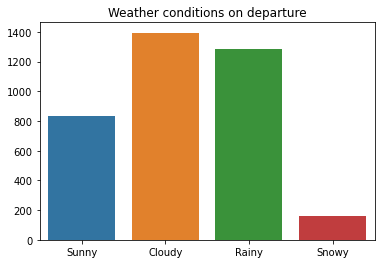

In [268]:
sns.barplot(x=np.array(conditions), y=np.array(list(map(len, conditions_dep))))
plt.title('Weather conditions on departure')
plt.show()

In [269]:
delays_dep = [cond.dep_delay.dropna() for cond in conditions_dep]

In [270]:
st.f_oneway(*delays_dep)

F_onewayResult(statistic=13.471001881895528, pvalue=9.694546839078932e-09)

In [287]:
def all_ts(conditions, delays):
    for i, condition_i in enumerate(conditions):
        for j, condition_j in enumerate(conditions):
            if j > i:
                pvalue = st.ttest_ind(delays[i], delays[j]).pvalue
                print(f'{condition_i} vs. {condition_j}: {pvalue}')

In [288]:
all_ts(conditions, delays_dep)

Sunny vs. Cloudy: 0.09490022871341328
Sunny vs. Rainy: 3.782544866970443e-06
Sunny vs. Snowy: 2.4133421875291294e-05
Cloudy vs. Rainy: 1.4136749973253727e-05
Cloudy vs. Snowy: 4.718770072345881e-05
Rainy vs. Snowy: 0.23965884165882329


The differences are highly significant for precipitation vs. no precipitation, not significant for sunny vs. cloudy or rainy vs. snowy. So we should just track whether there's precipitation.

In [279]:
sunny_arr = where_conditions(flights_with_weather, 'conditions_dest', 'clear')
cloudy_arr = pd.concat([
    where_conditions_exactly(flights_with_weather, 'conditions_dest', 'partially cloudy'),
    where_conditions_exactly(flights_with_weather, 'conditions_dest', 'overcast')
])
rainy_arr = where_conditions(flights_with_weather, 'conditions_dest', 'rain')
snowy_arr = where_conditions(flights_with_weather, 'conditions_dest', 'snow')

In [280]:
conditions_arr = [sunny_arr, cloudy_arr, rainy_arr, snowy_arr]

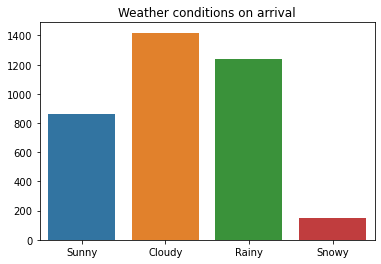

In [281]:
sns.barplot(x=np.array(conditions), y=np.array(list(map(len, conditions_arr))))
plt.title('Weather conditions on arrival')
plt.show()

In [284]:
delays_arr = [cond.arr_delay.dropna() for cond in conditions_arr]

In [285]:
st.f_oneway(*delays_arr)

F_onewayResult(statistic=8.633416511231825, pvalue=1.0447590584946732e-05)

In [289]:
all_ts(conditions, delays_arr)

Sunny vs. Cloudy: 0.9042800103776446
Sunny vs. Rainy: 5.720790348219822e-05
Sunny vs. Snowy: 0.030664765118207437
Cloudy vs. Rainy: 1.1737222273555975e-05
Cloudy vs. Snowy: 0.04053680750968717
Rainy vs. Snowy: 0.8387901100190414


Same as for departures, this is significant for precitpitation vs. no precipitation (though less so), and not significant for sunny vs. cloudy or rainy vs. snowy.

#### **Task 4**: How do taxi times change throughout the day? Does higher traffic lead to bigger taxi times?

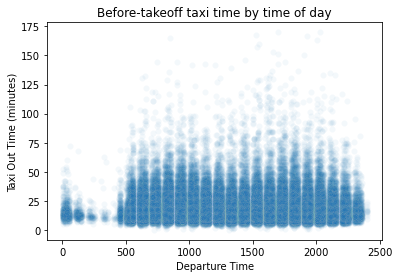

In [26]:
sns.scatterplot(data=flights, x='dep_time', y='taxi_out', alpha=0.05)
plt.xlabel('Departure Time')
plt.ylabel('Taxi Out Time (minutes)')
plt.title('Before-takeoff taxi time by time of day')
plt.show()

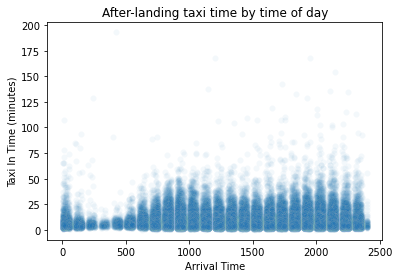

In [30]:
sns.scatterplot(data=flights, x='arr_time', y='taxi_in', alpha=0.05)
plt.xlabel('Arrival Time')
plt.ylabel('Taxi In Time (minutes)')
plt.title('After-landing taxi time by time of day')
plt.show()

In [49]:
outbound_traffic = flights.origin.value_counts().to_frame(name='flights')

In [51]:
outbound_traffic_taxi = flights[['taxi_out', 'origin']].merge(
    outbound_traffic, left_on='origin', right_index=True
)

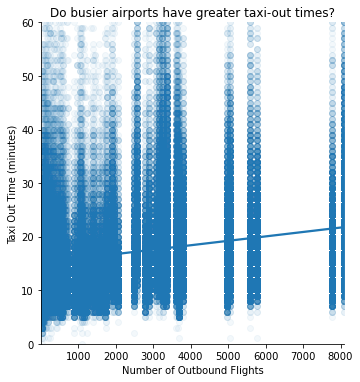

In [65]:
sns.lmplot(data=outbound_traffic_taxi, x='flights', y='taxi_out', scatter_kws=dict(alpha=0.05))
plt.ylim(0, 60)
plt.xlabel('Number of Outbound Flights')
plt.ylabel('Taxi Out Time (minutes)')
plt.title('Do busier airports have greater taxi-out times?')
plt.show()

But for actual training, it may be better to assume a logarithmic relationship

In [58]:
inbound_traffic = flights.dest.value_counts().to_frame(name='flights')

In [63]:
inbound_traffic_taxi = flights[['taxi_in', 'dest']].merge(
    outbound_traffic, left_on='dest', right_index=True
)

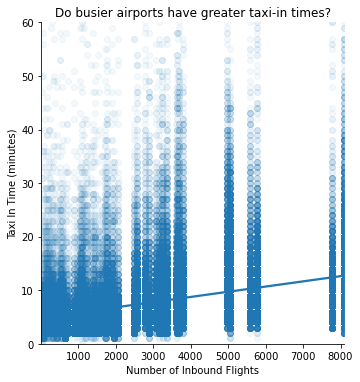

In [66]:
sns.lmplot(data=inbound_traffic_taxi, x='flights', y='taxi_in', scatter_kws=dict(alpha=0.05))
plt.ylim(0, 60)
plt.xlabel('Number of Inbound Flights')
plt.ylabel('Taxi In Time (minutes)')
plt.title('Do busier airports have greater taxi-in times?')
plt.show()

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [71]:
num_arr_delays = flights.arr_delay[flights.arr_delay > 0].count()
num_arr_delays

54832

In [74]:
num_arr_delays_with_dep_delay = flights.arr_delay[
    (flights.arr_delay > 0) & (flights.dep_delay > 0)
].count()
num_arr_delays_with_dep_delay

39112

In [75]:
num_arr_delays_with_bigger_dep_delay = flights.arr_delay[
    (flights.arr_delay > 0) & (flights.dep_delay >= flights.arr_delay)
].count()
num_arr_delays_with_bigger_dep_delay

24660

In [81]:
fr_arr_delays_with_dep_delay = num_arr_delays_with_dep_delay / num_arr_delays
f"{fr_arr_delays_with_dep_delay:.1%} of delayed arrivals also had delayed departures"

'71.3% of delayed arrivals also had delayed departures'

In [82]:
fr_arr_delays_with_bigger_dep_delay = num_arr_delays_with_bigger_dep_delay / num_arr_delays
f"{fr_arr_delays_with_bigger_dep_delay:.1%} of delayed arrivals had departure delays at least as long"

'45.0% of delayed arrivals had departure delays at least as long'

We can think of this range (45% to 71%) as bounds on the percentage of arrival delays that are caused by departure delays. At the upper bound, we're counting any departure delay as causing the arrival delay, even if there were also other causes. At the lower bound, we reason that if the departure delay isn't at least as long as the arrival delay, it can't be the only cause. This misses cases where the departure delay was still the primary cause (e.g. a 50 minute departure delay leading to a 52 minute arrival delay), but counts complicated cases where the departure was delayed, then the plane made up the lost time before being delayed again for unrelated reasons.

In [83]:
num_dep_delays = flights.dep_delay[flights.dep_delay > 0].count()
num_dep_delays

53502

In [84]:
num_dep_delays_with_smaller_arr_delay = flights.dep_delay[
    (flights.dep_delay > 0) & (flights.arr_delay <= flights.dep_delay)
].count()
num_dep_delays_with_smaller_arr_delay

38738

In [86]:
num_dep_delays_with_ontime_arr = flights.dep_delay[
    (flights.dep_delay > 0) & (flights.arr_delay <= 0)
].count()
num_dep_delays_with_ontime_arr

14078

In [89]:
fr_dep_delays_with_smaller_arr_delay = num_dep_delays_with_smaller_arr_delay / num_dep_delays
f"{fr_dep_delays_with_smaller_arr_delay:.1%} of delayed departures made up some of the time during flight"

'72.4% of delayed departures made up some of the time during flight'

In [90]:
fr_dep_delays_with_ontime_arr = num_dep_delays_with_ontime_arr / num_dep_delays
f"{fr_dep_delays_with_ontime_arr:.1%} of delayed departures arrived on time anyway"

'26.3% of delayed departures arrived on time anyway'

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [295]:
total_flights_by_airport = inbound_traffic + outbound_traffic

In [297]:
total_flights_by_airport.sort_values(by='flights', ascending=False).head(10)

,flights
ORD,15951.0
ATL,15813.0
DFW,11599.0
DEN,11307.0
CLT,9981.0
LAX,9972.0
SEA,7557.0
PHX,7277.0
IAH,7248.0
SFO,7187.0


In [299]:
passengers = pd.read_csv('../data/passengers_10%.csv')

In [301]:
passengers.columns

Index(['departures_scheduled', 'departures_performed', 'payload', 'seats',
       'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp', 'air_time',
       'unique_carrier', 'airline_id', 'unique_carrier_name', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_city_market_id', 'origin',
       'origin_city_name', 'origin_country', 'origin_country_name',
       'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name',
       'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type',
       'aircraft_config', 'year', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [313]:
passengers_outbound = passengers.groupby('origin').passengers.sum().to_frame()
passengers_inbound = passengers.groupby('dest').passengers.sum().to_frame()

In [311]:
total_passengers_by_airport = passengers_inbound + passengers_outbound

In [314]:
total_passengers_by_airport.sort_values(by='passengers', ascending=False).head(10)

,passengers
ATL,51818383.0
LAX,41097981.0
ORD,39440105.0
DFW,33407741.0
DEN,30880909.0
JFK,29857711.0
SFO,26376070.0
LAS,23342225.0
CLT,22295158.0
MCO,21987855.0


#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?